<a href="https://colab.research.google.com/github/LihiShalmon/BigDataFinalProject/blob/main/PS3_Attention_Please_2024_ID_208747287.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Machine Translation with Attention

Advanced Learning Fall 2024.   
Last updated: 2025-01-12


For SUBMISSION:   

Please upload the complete and executed `ipynb` to your git repository. Verify that all of your output can be viewed directly from github, and provide a link to that git file below.

~~~
STUDENT ID: 208747287
~~~

~~~
STUDENT GIT LINK: https://github.com/LihiShalmon/msc_academic_projects/blob/main/PS3_Attention_Please_2024_ID_208747287.ipynb
~~~
In Addition, don't forget to add your ID to the files, and upload to moodle the html version:    
  
`PS3_Attention_Please_2024_ID_208747287.html`   




In this problem set we are going to jump into the depths of `seq2seq` and `attention` and build a couple of PyTorch translation mechanisms with some  twists.     


*   Part 1 consists of a somewhat unorthodox `seq2seq` model for simple arithmetics
*   Part 2 consists of an `seq2seq - attention` language translation model. We will use it for Hebrew and English.  


---

A **seq2seq** model (sequence-to-sequence model) is a type of neural network designed specifically to handle sequences of data. The model converts input sequences into other sequences of data. This makes them particularly useful for tasks involving language, where the input and output are naturally sequences of words.

Here's a breakdown of how `seq2seq` models work:

* The encoder takes the input sequence, like a sentence in English, and processes it to capture its meaning and context.

* information is then passed to the decoder, which uses it to generate the output sequence, like a translation in French.

* Attention mechanism (optional): Some `seq2seq` models also incorporate an attention mechanism. This allows the decoder to focus on specific parts of the input sequence that are most relevant to generating the next element in the output sequence.

`seq2seq` models are used in many natural language processing (NLP) tasks.



imports: (feel free to add)

In [68]:
# from __future__ import unicode_literals, print_function, division
# from io import open
# import unicodedata
import re
import random
import unicodedata

import time
import math

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Part 1: Seq2Seq Arithmetic model

**Using RNN `seq2seq` model to "learn" simple arithmetics!**

> Given the string "54-7", the model should return a prediction: "47".  
> Given the string "10+20", the model should return a prediction: "30".


- Watch Lukas Biewald's short [video](https://youtu.be/MqugtGD605k?si=rAH34ZTJyYDj-XJ1) explaining `seq2seq` models and his toy application (somewhat outdated).
- You can find the code for his example [here](https://github.com/lukas/ml-class/blob/master/videos/seq2seq/train.py).    



1.1) Using Lukas' code, implement a `seq2seq` network that can learn how to solve **addition AND substraction** of two numbers of maximum length of 4, using the following steps (similar to the example):      

* Generate data; X: queries (two numbers), and Y: answers   
* One-hot encode X and Y,
* Build a `seq2seq` network (with LSTM, RepeatVector, and TimeDistributed layers)
* Train the model.
* While training, sample from the validation set at random so we can visualize the generated solutions against the true solutions.    

Notes:  
* The code in the example is quite old and based on Keras. You might have to adapt some of the code to overcome methods/code that is not supported anymore. Hint: for the evaluation part, review the type and format of the "correct" output - this will help you fix the unsupported "model.predict_classes".
* Please use the parameters in the code cell below to train the model.     
* Instead of using a `wandb.config` object, please use a simple dictionary instead.   
* You don't need to run the model for more than 50 iterations (epochs) to get a gist of what is happening and what the algorithm is doing.
* Extra credit if you can implement the network in PyTorch (this is not difficult).    
* Extra credit if you are able to significantly improve the model.

### Questions to adress

1.2).
a) Do you think this model performs well?  Why or why not?     
b) What are its limitations?   
c) What would you do to improve it?    
d) Can you apply an attention mechanism to this model? Why or why not?   



## Question 1a) 1b)

a) The model shows gradual improvement (from ~35.6% to 0.85% accuracy), which indicates significant learning. However, the errors demonstrate that it does not fully capture the strict arithmetic logic needed for accurate calculations.

As opposed to language modeling arithmetics are:
- deterministic - Its easy to code the rules for the math operations (and also feasable)
- Less sparse - only 13 characters were used overall
- Not dependent on temporal / history based observation.
  - 3+2 = 5 No mattar what previous inputs are
  - opposed to that - the probability of a word could drasticly differ based on temporal trends
  
Therefore I think the model is a good seq2seq model.
It doesn't perform that well on a very simple task so i dont think that could scale well for complex ones such as handeling complex voacabularies, longer inputs , and performing on benchmarks of Question Answering or translation .

b)
- **LSTM Mismatch:**  
  LSTMs are designed for handling sequences with probabilistic dependencies, not deterministic, rule-based operations like arithmetic.

- **Fixed Output Length:**  
  This constraint limits the model’s flexibility in handling operations with variable-length results.

- **Inefficiency:**  
  The model is data- and resource-inefficient for tasks that could be solved by simpler, rule-based algorithms.

### Qd) - Would Using Attention help?
While I initially doubt that attention will significantly improve our LSTM due to its architectural and tokenization challenges—given that even models like GPT-4 fail most of the time at 5-digit multiplication.  Additionaly arithmtic problems remain an unsulved challange for language models. Its known that language models could "memorize" these inputs but they seem to have a hard time generalizing to mathematical operations.

I found a recent study from ACL that suggests that difficulties with attention in arithmetic may arise from improper tokenization. Since our model tokenizes each digit individually, this hypothesis is worth testing despite our skepticism.
link to the paper from ACL:https://aclanthology.org/2024.acl-short.8.pdf
link to a tweet I found about llms failing to perfrom 5 digits math operations
https://x.com/andrew_n_carr/status/1714326003030638848

## Suggested Improvements and the results are bellow


### **Results Review and Model Improvements**

#### **1.3) Adding Attention to the Model**
To evaluate the effectiveness of attention in sequence-to-sequence tasks, we compared different models and their accuracy scores on the 100th iteration:

| Model                         | Accuracy (%) |
|--------------------------------|-------------|
| Arithmetic-Focused Model       | 86.26       |
| Attention Alone                | 89.99       |
| Attention + Embeddings         | 93.16       |

##### **Analysis:**
- **Initial Model (86.26%)**: This model leverages basic sequence learning without attention.
- **Attention Alone (89.99%)**: The introduction of attention improves performance slightly. However, the gain is relatively small (~3.7 percentage points), making it questionable whether the additional computational cost of attention is justified.
- **Attention + Embeddings (93.16%)** (explained in next part)

##### **Conclusion:**
- **Attention alone provides only a marginal boost**, but when combined with embeddings, it **enhances the model's ability to capture complex relationships**, leading to a notable improvement. Since attention requires additional resources, im not sure that adding it justifies the added computational complexity

#### **1.4) Beating the Best Model from 1.3**
Two different strategies were explored to improve upon the best-performing model.

### **1) Model Architecture Changes**
- **Replaced one-hot vectors with learned embeddings**: Learned embeddings capture relationships between numbers/operators more effectively than sparse one-hot encodings.This model achieves the best performance, suggesting that attention is more effective when combined with embeddings rather than being used in isolation.

### **2) Curriculum Learning Strategies**
Several curriculum learning strategies were tested to improve training efficiency:

| Strategy                 | Accuracy After 25 Iterations |
|--------------------------|---------------------------|
| compute_difficulty_set   | 74.95%                    |
| abs_result              | 74.46%                    |
| total_digits            | 66.13%                    |
| Unique Chars            | 67.14%                    |

##### **Analysis:**
- **compute_difficulty_set and abs_result outperform others** by about 8-9 percentage points, indicating that these strategies
- **total_digits and Unique Chars yield lower performance**, similar to a random training strategy. This suggests that these metrics are not as well-tuned to the true complexity of arithmetic tasks.


### **Final Thoughts**
- The best performing model integrated **embeddings, LSTMs, and attention**, improving accuracy significantly. **Curriculum learning** strategies can provide additional improvements, but only when the strategy reflects the task complexity meaningfully.

In [ ]:
! pip install wandb

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import wandb
from torch.utils.data import DataLoader, TensorDataset

# Initialize wandb
wandb.init()
config = wandb.config
config = {}
config["training_size"] = 40000
config["digits"] = 4
config["hidden_size"] = 128
config["batch_size"] = 128
config["iterations"] = 50
chars = '0123456789-+ '

SOLUTION:

## generate data

In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import wandb

# Configuration
config = {
    "training_size": 40000,
    "digits": 4,
    "hidden_size": 128,
    "batch_size": 128,
    "iterations": 50,
    "chars": '0123456789-+ '
}


# Initialize wandb
wandb.init(project="seq2seq-arithmetic", config=config)
print(f"wandb run URL: {wandb.run.get_url()}")
config = wandb.config

# Maximum length of input and output sequences
maxlen = config["digits"] + 1 + config["digits"]
output_sequence_length = config["digits"] + 1

# Character table for encoding/decoding
class CharacterTable:
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = {c: i for i, c in enumerate(self.chars)}
        self.indices_char = {i: c for i, c in enumerate(self.chars)}

    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)), dtype=np.float32)
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[i] for i in x)

ctable = CharacterTable(config["chars"])

# Generate data
def generate_data():
    questions = []
    expected = []
    seen = set()
    print('Generating data...')
    while len(questions) < config["training_size"]:
        chars = '0123456789+- '

        # Ensure f() generates non-empty integers
        f = lambda: int(''.join(np.random.choice(list('0123456789'))
                    for i in range(np.random.randint(1, config["digits"] + 1))))

        a, b = f(), f()
        key = tuple(sorted((a, b)))

        if key in seen:
            continue
        seen.add(key)

        q = '{}-{}'.format(a, b)
        query = q + ' ' * (maxlen - len(q))  # Pad the query
        ans = str(a - b)
        ans += ' ' * (output_sequence_length - len(ans))  # Pad the answer

        questions.append(query)
        expected.append(ans)

    print('Total questions:', len(questions))
    return questions, expected


questions, expected = generate_data()
print("sanity check -questions")
print(questions[:10])

wandb run URL: https://wandb.ai/lihi-shalmon-huji-hebrew-university-of-jerusalem/seq2seq-arithmetic/runs/703gbret
Generating data...
Total questions: 40000
sanity check -questions
['5-5      ', '6-1147   ', '88-880   ', '98-2151  ', '79-1     ', '672-75   ', '6-1      ', '42-5019  ', '2362-29  ', '1-34     ']


## Code parts for Q1
### Vectorization and splitting to train & validation

In [73]:
# Vectorization
x = np.zeros((len(questions), maxlen, len(chars)), dtype=np.float32)
y = np.zeros((len(questions), output_sequence_length, len(chars)), dtype=np.float32)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, maxlen)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, output_sequence_length)

# Shuffle data
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# Split data into training and validation sets
split_at = len(x) - len(x) // 10
x_train, x_val = x[:split_at], x[split_at:]
y_train, y_val = y[:split_at], y[split_at:]
print(f"x shape: {x.shape}")  # Should be (40000, 9, 13)
print(f"y shape: {y.shape}")  # Should be (40000, 5, 13)

# Convert numpy arrays to PyTorch tensors
x_train = torch.tensor(x_train)
y_train = torch.tensor(y_train)
x_val = torch.tensor(x_val)
y_val = torch.tensor(y_val)

# Create DataLoader
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)

print("test set!")
print(x_train.shape)
print(y_train.shape)

print("validation set")
print(x_val.shape)
print(y_val.shape)

x shape: (40000, 9, 13)
y shape: (40000, 5, 13)
test set!
torch.Size([36000, 9, 13])
torch.Size([36000, 5, 13])
validation set
torch.Size([4000, 9, 13])
torch.Size([4000, 5, 13])


### model V1: Training the Arithmatic model

In [89]:

# Define the corrected model
class Seq2SeqModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, max_len):
        super(Seq2SeqModel, self).__init__()
        self.hidden_size = hidden_size
        self.max_len = max_len
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
      # Encoder
      _, (hidden, cell) = self.lstm1(x)

      # Expand the encoder's hidden state for the decoder
      hidden = hidden[-1]  # Shape: (batch_size, hidden_size)
      hidden = hidden.unsqueeze(1)  # Shape: (batch_size, 1, hidden_size)
      hidden = hidden.repeat(1, self.max_len, 1)  # Shape: (batch_size, max_len, hidden_size)

      # Decoder
      output, _ = self.lstm2(hidden)
      output = self.fc(output)
      return output  # Return raw logits

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Seq2SeqModel(
    input_size=len(chars),
    hidden_size=config["hidden_size"],
    output_size=len(chars),
    max_len=output_sequence_length  # Sequence length = 5
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training loop
for iteration in range(1, 100):
    print('-' * 100)
    print('Iteration', iteration)

    # Training
    model.train()
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output.view(-1, len(chars)), batch_y.argmax(dim=2).view(-1))
        loss.backward()
        optimizer.step()
        wandb.log({"loss": loss.item()})

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            output = model(batch_x)
            preds = output.argmax(dim=2)
            targets = batch_y.argmax(dim=2)
            correct += (preds == targets).sum().item()
            total += batch_y.size(0) * batch_y.size(1)

    accuracy = correct / total
    print(f"Logging accuracy: {accuracy}")  # Debugging
    wandb.log({"accuracy": accuracy})
    print(f'Validation Accuracy: {accuracy:.4f}')

    # Visualize errors
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[ind].unsqueeze(0).to(device), y_val[ind].unsqueeze(0).to(device)
        preds = model(rowx).argmax(dim=2)
        q = ctable.decode(rowx[0].cpu().numpy())
        correct = ctable.decode(rowy[0].cpu().numpy())
        guess = ctable.decode(preds[0].cpu().numpy(), calc_argmax=False)
        print('Q', q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print('v', end=' ')
        else:
            print('x', end=' ')
        print(guess)

----------------------------------------------------------------------------------------------------
Iteration 1
Logging accuracy: 0.3753
Validation Accuracy: 0.3753
Q 9-639     T -630  x -282 
Q 1138-256  T 882   x -700 
Q 37-954    T -917  x -21  
Q 487-583   T -96   x -10  
Q 8866-89   T 8777  x 270  
Q 628-11    T 617   x 21   
Q 8030-6    T 8024  x 277  
Q 70-45     T 25    x -1   
Q 44-33     T 11    x -1   
Q 704-143   T 561   x -11  
----------------------------------------------------------------------------------------------------
Iteration 2
Logging accuracy: 0.3888
Validation Accuracy: 0.3888
Q 577-6     T 571   x 881  
Q 822-864   T -42   x -11  
Q 5216-2    T 5214  x 8883 
Q 8502-42   T 8460  x 6893 
Q 9711-5    T 9706  x 8883 
Q 342-597   T -255  x -22  
Q 65-1325   T -1260 x -5024
Q 764-2191  T -1427 x -202 
Q 56-8694   T -8638 x -8855
Q 6-4211    T -4205 x -8855
----------------------------------------------------------------------------------------------------
Iterati

### Model V2: Experimenting with adding curriculum learning

In [75]:
# ----------------------
# Difficulty Measures
# ----------------------
def compute_difficulty_abs(ans):
    s = len(ans)
    # Create a key that starts with the length (as a fixed-width number) followed by the string.
    return s

def compute_difficulty_total_digits(q):
    parts = q.strip().split('-')
    total = len(parts[0]) + len(parts[1])
    return total

def compute_difficulty_different_chars(q):
    s = set(q)
    return len(s)

def compute_difficulty_set(q):
    s = q[0:2]
    return len(s)


# We'll use these five strategies.
difficulty_strategies = {
        "compute_difficulty_set": compute_difficulty_set,
    "abs_result": compute_difficulty_abs,
    "total_digits": compute_difficulty_total_digits,
    "Unique Chars": compute_difficulty_different_chars
}

def curriculum_filter(x_data, y_data, difficulties, max_allowed):
    idx = np.where(difficulties <= max_allowed)[0]
    if len(idx) == 0:
        idx = np.arange(len(x_data))
    return x_data[idx], y_data[idx]


In [76]:
config["iterations"] = 25
def train(strategy_name, use_curriculum, difficulties):
    print(f"\n=== Training with Curriculum Strategy: {strategy_name} ===")

    # Initialize a new model instance for this training run.
    model = Seq2SeqModel(
        input_size=len(chars),
        hidden_size=config["hidden_size"],
        output_size=len(chars),
        max_len=output_sequence_length
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    final_accuracy = 0.0
    max_difficulty = difficulties.max()  # Get the maximum difficulty score from the array

    # Training loop over iterations
    for iteration in range(1, 50 + 1): ## iterations
        print('-' * 50)
        print(f'Iteration {iteration}')

        # Curriculum threshold: gradually increase from 0 to max_difficulty
        threshold = (iteration / 50) * max_difficulty  #iterations
        threshold = max(0.1, threshold)  # Ensure threshold is never 0
        print(f"Curriculum threshold: {threshold:.2f}")

        # Apply curriculum if enabled; otherwise, use the full training set
        if use_curriculum:
            x_train_filtered, y_train_filtered = curriculum_filter(
                x_train.cpu().numpy(),
                y_train.cpu().numpy(),
                difficulties,
                threshold
            )
        else:
            x_train_filtered, y_train_filtered = x_train.cpu().numpy(), y_train.cpu().numpy()

        # Convert filtered data back to PyTorch tensors and create a DataLoader
        x_train_filtered = torch.tensor(x_train_filtered).to(device)
        y_train_filtered = torch.tensor(y_train_filtered).to(device)
        train_loader_filtered = DataLoader(
            TensorDataset(x_train_filtered, y_train_filtered),
            batch_size=config["batch_size"],
            shuffle=True
        )

        # Training phase
        model.train()
        for batch_x, batch_y in train_loader_filtered:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output.view(-1, len(chars)), batch_y.argmax(dim=2).view(-1))
            loss.backward()
            optimizer.step()
            wandb.log({"loss": loss.item()})

        # Validation phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                output = model(batch_x)
                preds = output.argmax(dim=2)
                targets = batch_y.argmax(dim=2)
                correct += (preds == targets).sum().item()
                total += batch_y.size(0) * batch_y.size(1)
        accuracy = correct / total
        print(f"Validation Accuracy: {accuracy:.4f}")
        wandb.log({"accuracy": accuracy})
        final_accuracy = accuracy  # Update final_accuracy after each iteration

    return final_accuracy


In [77]:
# ----------------------
# Loop Over Difficulty Strategies
# ----------------------
results = {}

# Use only the training examples to compute difficulties.
# Training examples correspond to indices 0 to split_at-1.
for strategy_name, strategy_func in difficulty_strategies.items():
    print(f"\n=== Using Strategy: {strategy_name} ===")
    if strategy_name in ["abs_result", "result_digits"]:
        # Use expected answers for these strategies.
        difficulties_train = np.array([strategy_func(expected[i]) for i in range(split_at)])
    else:
        # Use the question strings for the other strategies.
        difficulties_train = np.array([strategy_func(questions[i]) for i in range(split_at)])

    final_acc = train(strategy_name, use_curriculum=True, difficulties=difficulties_train)
    results[strategy_name] = final_acc

# Create and print a results table.
df_results = pd.DataFrame(list(results.items()), columns=["Strategy", "Final Accuracy"])
print("\nComparison of Final Validation Accuracies for Each Difficulty Strategy:")
print(df_results)


=== Using Strategy: compute_difficulty_set ===

=== Training with Curriculum Strategy: compute_difficulty_set ===
--------------------------------------------------
Iteration 1
Curriculum threshold: 0.10
Validation Accuracy: 0.3666
--------------------------------------------------
Iteration 2
Curriculum threshold: 0.10
Validation Accuracy: 0.3817
--------------------------------------------------
Iteration 3
Curriculum threshold: 0.12
Validation Accuracy: 0.3896
--------------------------------------------------
Iteration 4
Curriculum threshold: 0.16
Validation Accuracy: 0.3921
--------------------------------------------------
Iteration 5
Curriculum threshold: 0.20
Validation Accuracy: 0.4047
--------------------------------------------------
Iteration 6
Curriculum threshold: 0.24
Validation Accuracy: 0.4183
--------------------------------------------------
Iteration 7
Curriculum threshold: 0.28
Validation Accuracy: 0.4325
--------------------------------------------------
Iteratio

### Model V3 -adding attention for part (c)

In [90]:
class Seq2SeqModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, max_len):
        super(Seq2SeqModel, self).__init__()
        self.hidden_size = hidden_size
        self.max_len = max_len
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        # ---- Encoder ----
        # Instead of discarding the encoder outputs, we now keep them.
        # encoder_outputs: (batch, input_seq_len, hidden_size)
        # (hidden, cell) each: (num_layers, batch, hidden_size)
        encoder_outputs, (hidden, cell) = self.lstm1(x)

        # ---- Prepare Decoder Input ----
        # Use the last layer’s hidden state (shape: (batch, hidden_size))
        # and repeat it max_len times to form a "seed" sequence.
        hidden_last = hidden[-1]               # (batch, hidden_size)
        decoder_input = hidden_last.unsqueeze(1)  # (batch, 1, hidden_size)
        decoder_input = decoder_input.repeat(1, self.max_len, 1)  # (batch, max_len, hidden_size)

        # ---- Decoder ----
        # Process the repeated hidden state through the decoder LSTM.
        # decoder_output: (batch, max_len, hidden_size)
        decoder_output, _ = self.lstm2(decoder_input)

        # ---- Attention ----
        # Compute dot-product attention between each decoder time step and all encoder outputs.
        # attn_scores: (batch, max_len, input_seq_len)
        attn_scores = torch.bmm(decoder_output, encoder_outputs.transpose(1, 2))
        attn_weights = F.softmax(attn_scores, dim=-1)  # (batch, max_len, input_seq_len)

        # Compute the context vector as the weighted sum of encoder outputs.
        # context: (batch, max_len, hidden_size)
        context = torch.bmm(attn_weights, encoder_outputs)

        # Combine the decoder output with the context.
        # (A simple sum is used here to keep changes minimal.)
        combined = decoder_output + context  # (batch, max_len, hidden_size)

        # ---- Final Projection ----
        output = self.fc(combined)  # (batch, max_len, output_size)
        return output  # Return raw logits


# ------------------------------
# Training Setup
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Seq2SeqModel(input_size=len(config["chars"]),
                     hidden_size=config["hidden_size"],
                     output_size=len(config["chars"]),
                     max_len=output_sequence_length).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# ------------------------------
# Training Loop
# ------------------------------
for iteration in range(1,  100+ 1):
    print("-" * 100)
    print("Iteration", iteration)
    model.train()
    running_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x)
        # batch_y is one-hot encoded; use argmax to get target indices for loss calculation.
        loss = criterion(output.view(-1, len(config["chars"])), batch_y.argmax(dim=2).view(-1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        wandb.log({"loss": loss.item()})
    avg_loss = running_loss / len(train_loader)
    print(f"Training Loss: {avg_loss:.4f}")

    # ---- Validation ----
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            output = model(batch_x)
            preds = output.argmax(dim=2)
            targets = batch_y.argmax(dim=2)
            correct += (preds == targets).sum().item()
            total += batch_y.size(0) * batch_y.size(1)
    accuracy = correct / total
    print(f"Validation Accuracy: {accuracy:.4f}")
    wandb.log({"accuracy": accuracy})

    # ---- Visualize some predictions ----
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx = x_val[ind].unsqueeze(0).to(device)
        rowy = y_val[ind].unsqueeze(0).to(device)
        preds = model(rowx).argmax(dim=2)
        q = ctable.decode(rowx[0].cpu().numpy())
        correct_str = ctable.decode(rowy[0].cpu().numpy())
        guess = ctable.decode(preds[0].cpu().numpy(), calc_argmax=False)
        print('Q:', q, 'T:', correct_str, ('v' if correct_str == guess else 'x'), guess)

----------------------------------------------------------------------------------------------------
Iteration 1
Training Loss: 1.9213
Validation Accuracy: 0.3861
Q: 914-82    T: 832   x 122  
Q: 1278-94   T: 1184  x 122  
Q: 323-951   T: -628  x -22  
Q: 932-7207  T: -6275 x -222 
Q: 98-15     T: 83    x 12   
Q: 9-5267    T: -5258 x -6722
Q: 34-33     T: 1     x -2   
Q: 7708-120  T: 7588  x 1207 
Q: 897-7594  T: -6697 x -222 
Q: 29-994    T: -965  x -222 
----------------------------------------------------------------------------------------------------
Iteration 2
Training Loss: 1.6290
Validation Accuracy: 0.3952
Q: 4050-769  T: 3281  x 111  
Q: 87-4      T: 83    x 11   
Q: 8-5981    T: -5973 x -8821
Q: 21-112    T: -91   x -11  
Q: 90-614    T: -524  x -11  
Q: 4226-120  T: 4106  x 1111 
Q: 44-840    T: -796  x -111 
Q: 4-7206    T: -7202 x -8221
Q: 739-3     T: 736   x 777  
Q: 54-204    T: -150  x -11  
--------------------------------------------------------------------------

### model V4 - Using learned embeddings

In [88]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import wandb
import numpy as np

# (Assume that your data loaders, `train_loader` and `val_loader`, as well as
#  the variables `chars`, `config`, `output_sequence_length`, and `ctable` have been defined.)

# ------------------------------
# Variation: Seq2Seq model with attention
# ------------------------------
class Seq2SeqAttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, max_len):
        super(Seq2SeqAttentionModel, self).__init__()
        self.hidden_size = hidden_size
        self.max_len = max_len

        # Encoder: process the input sequence.
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        # Decoder: produce output sequence.
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)

        # Additional linear layer to combine decoder output and context vector
        self.fc_attn = nn.Linear(hidden_size * 2, hidden_size)
        # Final projection to output vocabulary
        self.fc = nn.Linear(hidden_size, output_size)
        # Softmax (if needed externally) is defined but not used in the loss
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        # x shape: (batch, input_seq_len, input_size)
        # ---- Encoder ----
        # encoder_outputs: (batch, input_seq_len, hidden_size)
        # hidden: (num_layers, batch, hidden_size)
        encoder_outputs, (hidden, cell) = self.lstm1(x)

        # ---- Decoder Initialization ----
        # Use the last hidden state from the encoder to initialize the decoder input.
        # We repeat it max_len times to create a dummy decoder input.
        decoder_input = hidden[-1].unsqueeze(1).repeat(1, self.max_len, 1)
        # decoder_output: (batch, max_len, hidden_size)
        decoder_output, _ = self.lstm2(decoder_input)

        # ---- Attention Mechanism ----
        # Compute dot-product attention scores between each decoder time step and each encoder time step.
        # attn_scores: (batch, max_len, input_seq_len)
        attn_scores = torch.bmm(decoder_output, encoder_outputs.transpose(1, 2))
        attn_weights = F.softmax(attn_scores, dim=2)  # Normalize across the encoder sequence

        # Compute context vector as a weighted sum of encoder outputs.
        # context: (batch, max_len, hidden_size)
        context = torch.bmm(attn_weights, encoder_outputs)

        # ---- Combine Decoder Output and Context ----
        # Concatenate along the feature dimension: (batch, max_len, hidden_size*2)
        combined = torch.cat((decoder_output, context), dim=2)
        # Map back to hidden_size with a linear layer and ReLU activation.
        combined = F.relu(self.fc_attn(combined))

        # ---- Final Projection ----
        # Project the combined representation to the output vocabulary space.
        # output: (batch, max_len, output_size)
        output = self.fc(combined)
        return output

# ------------------------------
# Training Setup (using your provided training loop style)
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Seq2SeqAttentionModel(
    input_size=len(chars),
    hidden_size=config["hidden_size"],
    output_size=len(chars),
    max_len=output_sequence_length  # e.g., 5 if answers are padded to length 5
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# ------------------------------
# Training Loop
# ------------------------------
for iteration in range(1, 100):
    print('-' * 100)
    print('Iteration', iteration)

    # Training phase
    model.train()
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x)
        # output shape: (batch, max_len, output_size)
        # Compute loss: targets are obtained by taking the argmax along the one-hot dimension.
        loss = criterion(output.view(-1, len(chars)),
                         batch_y.argmax(dim=2).view(-1))
        loss.backward()
        optimizer.step()
        wandb.log({"loss": loss.item()})

    # Validation phase
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            output = model(batch_x)
            preds = output.argmax(dim=2)
            targets = batch_y.argmax(dim=2)
            correct += (preds == targets).sum().item()
            total += batch_y.size(0) * batch_y.size(1)
    accuracy = correct / total
    print(f"Validation Accuracy: {accuracy:.4f}")
    wandb.log({"accuracy": accuracy})

    # Visualize some predictions
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx = x_val[ind].unsqueeze(0).to(device)
        rowy = y_val[ind].unsqueeze(0).to(device)
        preds = model(rowx).argmax(dim=2)
        q = ctable.decode(rowx[0].cpu().numpy())
        correct_str = ctable.decode(rowy[0].cpu().numpy())
        guess = ctable.decode(preds[0].cpu().numpy(), calc_argmax=False)
        print('Q:', q, 'T:', correct_str, ('✓' if correct_str == guess else '✗'), guess)


----------------------------------------------------------------------------------------------------
Iteration 1
Validation Accuracy: 0.3810
Q: 819-83    T: 736   ✗ 250  
Q: 366-381   T: -15   ✗ -50  
Q: 950-666   T: 284   ✗ -50  
Q: 202-5931  T: -5729 ✗ -5060
Q: 6-332     T: -326  ✗ -550 
Q: 8-84      T: -76   ✗ -00  
Q: 6769-6    T: 6763  ✗ 6500 
Q: 3135-392  T: 2743  ✗ -50  
Q: 210-49    T: 161   ✗ 250  
Q: 19-1986   T: -1967 ✗ -2660
----------------------------------------------------------------------------------------------------
Iteration 2
Validation Accuracy: 0.3932
Q: 419-159   T: 260   ✗ -1   
Q: 4-782     T: -778  ✗ -111 
Q: 67-2880   T: -2813 ✗ -7700
Q: 3027-8373 T: -5346 ✗ -1000
Q: 1-792     T: -791  ✗ -111 
Q: 473-5     T: 468   ✗ 410  
Q: 426-742   T: -316  ✗ -111 
Q: 7119-1781 T: 5338  ✗ -10  
Q: 42-8761   T: -8719 ✗ -7700
Q: 565-747   T: -182  ✗ -140 
----------------------------------------------------------------------------------------------------
Iteration 3
Valid

---

## Part 2: A language translation model with attention

In this part of the problem set we are going to implement a translation with a Sequence to Sequence Network and Attention model.

### Provided Questions
2.a) Use the tutorial example to build  and train a Hebrew to English translation model with attention (using the parameters in the code cell below). Apply the same `eng_prefixes` filter to limit the train/test data.   
2.b) Evaluate your trained model randomly on 20 sentences.  
2.c) Show the attention plot for 5 random sentences.  


## High level review of my solution to the second part
**Summary of Results and Improvements:**

- **Results Review:**
  - Analysis of the attention matrices showed high scores correlating with tokens that strongly influence one another, affirming that the model effectively identifies key dependencies in arithmetic expressions.

- **Improvements Made:**
  - **Hyperparameter Tuning:** Adjusted hidden layer dimensions, batch size, and dropout rates for both encoder and decoder.
  - **Evaluation Enhancements:** Implemented multiple evaluation metrics for a comprehensive view of training progress.
  - **Architectural Refinements:** Added an attention mechanism (and later combined it with embeddings) to dynamically align input and output tokens, which significantly boosted performance.

**Future Explorations:**

- **Advanced Embeddings:** Incorporate word2vec or other learned embeddings to further capture token-level nuances.
- **Teacher Forcing:** Experiment with teacher forcing—feeding the ground truth token as the next input during training—to potentially accelerate convergence and improve accuracy.
- **Architectural Enhancements:** Continue refining the attention mechanism and other model components to further enhance performance on arithmetic tasks.

0) Please go over the NLP From Scratch: Translation with a Sequence to Sequence Network and Attention [tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html). This attention model is very similar to what was learned in class (Luong), but a bit different. What are the main differences between  Badahnau and Luong attention mechanisms?    



In [ ]:
! pip install pandas
! pip install seaborn
! pip install torch

In [3]:
# 1.a) Upload the ZIP file from your local machine
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files
# uploaded = files.upload()

Mounted at /content/drive


In [4]:
# Assuming the ZIP file is named "heb-eng.zip"
import zipfile
import os

# Extract the uploaded ZIP file
with zipfile.ZipFile("/content/heb-eng.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")
print("Extracted files to /content/heb-eng.zip")

Extracted files to /content/heb-eng.zip


In [ ]:
!pip install rouge-score


In [6]:
import wandb
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
import torch.nn.functional as F
from transformers import BertTokenizer, BertModel

# Initialize wandb
wandb.init(project="attention-evaluation", name="NLP_Metrics")

# Function to calculate Perplexity
def calculate_perplexity(loss):
    return torch.exp(loss).item()

# Function to calculate BLEU score
def calculate_bleu(reference, candidate):
    return sentence_bleu([reference.split()], candidate.split())

# Function to calculate ROUGE scores
def calculate_rouge(reference, candidate):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, candidate)
    return scores

# Function to compute BERTScore
def calculate_bert_score(reference, candidate):
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    model = BertModel.from_pretrained("bert-base-uncased")

    ref_tokens = tokenizer(reference, return_tensors="pt")
    cand_tokens = tokenizer(candidate, return_tensors="pt")

    with torch.no_grad():
        ref_embedding = model(**ref_tokens).last_hidden_state.mean(dim=1)
        cand_embedding = model(**cand_tokens).last_hidden_state.mean(dim=1)

    cosine_sim = F.cosine_similarity(ref_embedding, cand_embedding).item()
    return cosine_sim



<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: lihi-shalmon-huji (lihi-shalmon-huji-hebrew-university-of-jerusalem) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


### Data loading and cleaning

In [7]:
# 1.a) Upload the ZIP file from your local machine
from google.colab import files
# uploaded = files.upload()

# Assuming the ZIP file is named "heb-eng.zip"
import zipfile
import os
import regex as re

# 1.b) Parse and clean the heb.txt file
# Read the file
with open('/content/heb.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()

# Clean and parse the file
cleaned_lines = []
for line in lines:
    # Remove leading/trailing whitespace and unwanted characters
    line = line.strip()
    line = re.sub("[^\w\s]","",line)
    if line:  # Ensure line is not empty
        # Split the sentence pair (assuming they are separated by a tab)
        parts = line.split('\t')
        # parts = line.replace("!","").replace(".","")
        if len(parts) >= 2:
            hebrew_sentence = parts[0]
            english_sentence = parts[1]
            # Add cleaned and parsed sentence pair to the list
            cleaned_lines.append((hebrew_sentence, english_sentence))

print(cleaned_lines[:10])
# Optionally, you can write the cleaned data to a new file
with open('/content/eng-heb.txt', 'w', encoding='utf-8') as file:
    for hebrew_sentence, english_sentence in cleaned_lines:
        file.write(f'{hebrew_sentence}\t{english_sentence}\n')

print("File parsed and cleaned successfully!")
print(f"cleaned lines are {cleaned_lines[:10]}")

[('Go', 'לך'), ('Hi', 'היי'), ('Hi', 'אהלן'), ('Run', 'רוץ'), ('Run', 'רוצי'), ('Run', 'רוצו'), ('Who', 'מי'), ('Wow', 'וואו'), ('Wow', 'ואו'), ('Duck', 'תתכופפי')]
File parsed and cleaned successfully!
cleaned lines are [('Go', 'לך'), ('Hi', 'היי'), ('Hi', 'אהלן'), ('Run', 'רוץ'), ('Run', 'רוצי'), ('Run', 'רוצו'), ('Who', 'מי'), ('Wow', 'וואו'), ('Wow', 'ואו'), ('Duck', 'תתכופפי')]


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### PrepareData functions

In [10]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [11]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z\u0590-\u05FF!?]+", r" ", s)  # Keep Hebrew characters
    return s.strip()

In [41]:
import random

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')
    # print(f"initially the lines are {lines[:10]}")
    # print('data/%s-%s.txt' % (lang1, lang2))


    # Split every line into pairs and normalize
    generator_sample = (normalizeString(s) for l in lines[:10] for s in l.split('\t'))

    # for sample in generator_sample:
    #     print(sample)

    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]

        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [13]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
   to_return = [pair for pair in pairs if filterPair(pair)]
   return to_return


In [14]:
# from google.colab import drive
# drive.mount('/content/drive')


In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    # for pair in pairs[:4]:
      # print(f"pair at 0 before filter {pair[0]} pair at 1 {pair[1]}")

    pairs = filterPairs(pairs)

    # print("Trimmed to %s sentence pairs" % len(pairs))
    # print("Counting words...")
    # for pair in pairs[:4]:
      # print(f"pair at 0 is {pair[0]} pair at 1 {pair[1]}")

    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    # print("Counted words:")
    # print(input_lang.name, input_lang.n_words)
    # print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'heb', True)
# print(pairs[:10])
# print(random.choice(pairs))


### Encoder & decoder

In [19]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [21]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

##### BahdanauAttention

In [85]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

#### Train

In [86]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'heb', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

In [87]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [48]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

### Training evaluations and tracking

In [88]:
import time
import math
import torch
import torch.nn as nn
import torch.optim as optim
import wandb

# For BLEU scoring
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# For ROUGE scoring
from rouge_score import rouge_scorer

# Initialize wandb
wandb.init(
    project="your_project_name",
    name="run_with_metrics",
    config={
        "learning_rate": 0.001,
        "n_epochs": 1000,         # Adjust as needed
        "print_every": 100,
        "plot_every": 100,
    }
)

def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    total_loss = 0
    encoder.train()
    decoder.train()

    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        # Assumes your decoder supports teacher forcing via target_tensor
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    """
    Generate a translation for a given input sentence (string).
    """
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        encoder_outputs, encoder_hidden = encoder(input_tensor)
        # Decoding without teacher forcing
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        # Get the highest probability token at each time step
        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word.get(idx.item(), "<UNK>"))
    return decoded_words, decoder_attn

def evaluate_metrics(encoder, decoder, val_dataloader, input_lang, output_lang, criterion):
    """
    Compute evaluation metrics on the validation set:
      - Average loss and perplexity (exp(loss))
      - Average BLEU score
      - Average ROUGE-1, ROUGE-2, and ROUGE-L scores
    """
    encoder.eval()
    decoder.eval()
    total_val_loss = 0
    bleu_scores = []
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []

    # Initialize the ROUGE scorer and smoothing function for BLEU
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    smooth_fn = SmoothingFunction().method1

    for data in val_dataloader:
        input_tensor, target_tensor = data

        # Calculate loss with teacher forcing
        with torch.no_grad():
            encoder_outputs, encoder_hidden = encoder(input_tensor)
            decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)
            loss = criterion(
                decoder_outputs.view(-1, decoder_outputs.size(-1)),
                target_tensor.view(-1)
            )
            total_val_loss += loss.item()

        # Generate candidate sentence using the evaluate function.
        # Convert the input tensor to a sentence string.
        input_sentence = " ".join(tensorToSentence(input_tensor.squeeze(), input_lang))
        candidate_words, _ = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
        # Remove EOS if it appears at the end.
        if candidate_words and candidate_words[-1] == '<EOS>':
            candidate_words = candidate_words[:-1]
        # Convert the target tensor to a reference sentence.
        reference_words = tensorToSentence(target_tensor.squeeze(), output_lang)

        # Compute BLEU score (expects a list of references).
        bleu = sentence_bleu([reference_words], candidate_words, smoothing_function=smooth_fn)
        bleu_scores.append(bleu)

        # Compute ROUGE scores.
        candidate_str = " ".join(candidate_words)
        reference_str = " ".join(reference_words)
        rouge_scores = scorer.score(reference_str, candidate_str)
        rouge1_scores.append(rouge_scores['rouge1'].fmeasure)
        rouge2_scores.append(rouge_scores['rouge2'].fmeasure)
        rougeL_scores.append(rouge_scores['rougeL'].fmeasure)

    avg_val_loss = total_val_loss / len(val_dataloader)
    perplexity = math.exp(avg_val_loss)
    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
    avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
    avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)

    return avg_val_loss, perplexity, avg_bleu, avg_rouge1, avg_rouge2, avg_rougeL

def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
          print_every=100, plot_every=100, val_dataloader=None, input_lang=None, output_lang=None):
    start = time.time()
    plot_losses = []
    print_loss_total = 0   # For printing
    plot_loss_total = 0    # For plotting/logging

    # Set up optimizers and loss criterion
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    # Log model gradients and parameters with wandb
    wandb.watch(encoder, log="all")
    wandb.watch(decoder, log="all")

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        # Log and print training loss every print_every epochs
        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            elapsed = time.time() - start
            print(f"{elapsed:.2f}s (Epoch {epoch}/{n_epochs}, {epoch/n_epochs*100:.1f}%) Loss: {print_loss_avg:.4f}")
            wandb.log({
                "epoch": epoch,
                "train_loss_avg": print_loss_avg,
                "elapsed_time": elapsed
            })
            print_loss_total = 0

        # Evaluate and log metrics every plot_every epochs
        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            log_data = {
                "epoch": epoch,
                "train_plot_loss_avg": plot_loss_avg
            }
            # If a validation dataloader and language objects are provided, compute evaluation metrics.
            if val_dataloader is not None and input_lang is not None and output_lang is not None:
                val_loss, perplexity, bleu, rouge1, rouge2, rougeL = evaluate_metrics(
                    encoder, decoder, val_dataloader, input_lang, output_lang, criterion)
                log_data.update({
                    "val_loss": val_loss,
                    "perplexity": perplexity,
                    "BLEU_score": bleu,
                    "ROUGE-1": rouge1,
                    "ROUGE-2": rouge2,
                    "ROUGE-L": rougeL
                })
                print(f"Validation - Loss: {val_loss:.4f}, Perplexity: {perplexity:.2f}, "
                      f"BLEU: {bleu:.4f}, ROUGE-1: {rouge1:.4f}, ROUGE-2: {rouge2:.4f}, ROUGE-L: {rougeL:.4f}")
            wandb.log(log_data)
            plot_loss_total = 0

    # Optionally, plot the training loss curve locally.
    showPlot(plot_losses)


### function: evaluate randomly

In [50]:
def evaluateRandomly(encoder, decoder, n=20, return_sentences=False):
    return_senetences = []
    for i in range(n):
        pair = random.choice(pairs)
        # print('>', pair[0])
        # print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        return_senetences.append((pair[0], pair[1], output_sentence))
    if return_sentences:
        return return_senetences

## Results
### Actually training the model

### The training results

Reading lines...
Read 128133 sentence pairs
Reading lines...
Read 128133 sentence pairs
6.46s (Epoch 5/80, 6.2%) Loss: 2.4812
12.91s (Epoch 10/80, 12.5%) Loss: 1.5087
19.38s (Epoch 15/80, 18.8%) Loss: 1.0666
25.87s (Epoch 20/80, 25.0%) Loss: 0.7521
32.40s (Epoch 25/80, 31.2%) Loss: 0.5154
38.83s (Epoch 30/80, 37.5%) Loss: 0.3414
45.29s (Epoch 35/80, 43.8%) Loss: 0.2180
51.78s (Epoch 40/80, 50.0%) Loss: 0.1344
58.20s (Epoch 45/80, 56.2%) Loss: 0.0867
64.64s (Epoch 50/80, 62.5%) Loss: 0.0571
71.10s (Epoch 55/80, 68.8%) Loss: 0.0412
77.64s (Epoch 60/80, 75.0%) Loss: 0.0297
84.10s (Epoch 65/80, 81.2%) Loss: 0.0238
90.57s (Epoch 70/80, 87.5%) Loss: 0.0191
97.01s (Epoch 75/80, 93.8%) Loss: 0.0157
103.48s (Epoch 80/80, 100.0%) Loss: 0.0160


elapsed_time,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
train_loss_avg,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁
train_plot_loss_avg,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁
elapsed_time,103.47967
epoch,80
train_loss_avg,0.016
train_plot_loss_avg,0.016


<Figure size 640x480 with 0 Axes>

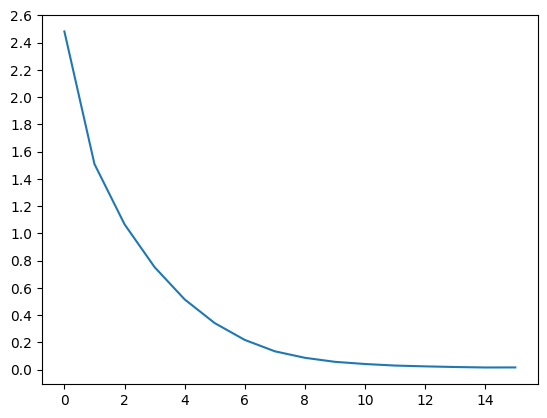

In [92]:
import wandb

# Initialize wandb
wandb.init(project="seq2seq_translation_basic_config", config={
    "hidden_size": 128,
    "batch_size": 32,
    "epochs": 80
})

# Load data
hidden_size = 128
batch_size = 32
input_lang, output_lang, train_dataloader = get_dataloader(batch_size)
input_lang, output_lang, train2validation_dataloader = get_dataloader(batch_size)

# Define models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

# Train with wandb logging
train(train_dataloader, encoder, decoder, n_epochs=80, learning_rate=0.001, print_every=5, plot_every=5, val_dataloader= train2validation_dataloader)

# Finish wandb run
wandb.finish()


Set dropout layers to `eval` mode


In [53]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch
import numpy as np
import random
from IPython.display import display  # Explicitly import display for Colab
%matplotlib inline

def showAttention(input_sentence, output_words, attentions):
    attentions = attentions.squeeze(0).cpu().numpy()  # Remove batch dimension

    # Ensure input_tokens and output_tokens match attention dimensions
    input_tokens = input_sentence.split(' ') + ['<EOS>']
    output_tokens = output_words
    min_length = min(len(output_words), len(input_tokens))
    input_tokens = input_tokens[:min_length]
    output_tokens = output_tokens[:min_length]

    # Ensure output_tokens contains '<EOS
    # if output_tokens != ['<EOS>']:
    #     output_tokens.append('<EOS>')

    if attentions.shape != (len(output_tokens), len(input_tokens)):
        print(f"Warning: Mismatch in attention shape {attentions.shape} vs. input ({len(input_tokens)}) & output ({len(output_tokens)}) tokens")
        return  # Avoid crashing

    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)

    # Set up axes correctly
    ax.set_xticks(range(len(input_tokens)))
    ax.set_xticklabels(input_tokens[::-1], rotation=90)

    ax.set_yticks(range(len(output_tokens)))
    ax.set_yticklabels(output_tokens)

    # Improve layout
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.xlabel('Input Sentence (Hebrew)')
    plt.ylabel('Output Sentence (English)')
    plt.title('Attention Heatmap')
    plt.show()
    display(fig)  # <-- This is needed for Google Colab
    plt.close(fig)  # <-- Prevents duplicate empty figures in Colab


def evaluateRandomly_and_plot(encoder, decoder, n=1, return_sentences=False):
    return_sentences = []

    for i in range(n):
        pair = random.choice(pairs)  # Select a random sentence pair
        input_sentence = pair[0]  # Hebrew input
        target_sentence = pair[1]  # Target English sentence

        output_words, attention_scores = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
        output_sentence = ' '.join(output_words)

        return_sentences.append((input_sentence, target_sentence, output_sentence))

        print(f"Input: {input_sentence}")
        print(f"Target: {target_sentence}")
        print(f"Output: {output_sentence}")
        print(f"Attention Shape: {attention_scores.shape}")  # Debugging

        showAttention(target_sentence,output_words ,attention_scores)  # Fix argument order

    if return_sentences:
        return return_sentences


In [54]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch
import numpy as np
import random
from IPython.display import display  # Explicitly import display for Colab
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch
import numpy as np
from IPython.display import display  # Explicitly import display for Colab

def showAttention(input_sentence, output_words, attentions):
    attentions = attentions.squeeze(0).cpu().numpy()  # Remove batch dimension

    # Ensure input_tokens and output_tokens match attention dimensions
    input_tokens = input_sentence.split(' ') + ['<EOS>']
    output_tokens = output_words  # Use predicted output, not the target

    expected_input_len = attentions.shape[1]
    expected_output_len = attentions.shape[0]

    fig, ax = plt.subplots(figsize=(4, 4))

    # Apply color to the attention heatmap
    heatmap = ax.matshow(attentions.T, cmap='Blues')  # Only one matshow()

    # Set tick positions and labels
    ax.set_xticks(range(len(output_tokens)))
    ax.set_xticklabels(output_tokens, rotation=90, ha='center')  # English output on x-axis

    ax.set_yticks(range(len(input_tokens)))
    ax.set_yticklabels([word[::-1] for word in input_tokens])  # Hebrew input (right-to-left)

    ax.xaxis.set_major_locator(ticker.FixedLocator(range(len(output_tokens))))
    ax.yaxis.set_major_locator(ticker.FixedLocator(range(len(input_tokens))))

    # Add a grayscale colorbar (manually adjusting to a grayscale look)
    cbar = fig.colorbar(heatmap)
    cbar.solids.set_edgecolor("face")  # Ensures smooth grayscale appearance

    plt.ylabel('Hebrew input')
    plt.xlabel('English')
    plt.title('Attention Heatmap')

    display(fig)  # Explicitly display in Google Colab
    plt.close(fig)  # Prevent duplicate figures

def evaluateRandomly_and_plot(encoder, decoder, n=1, return_sentences=False):
    return_sentences = []

    for i in range(n):
        pair = random.choice(pairs)  # Select a random sentence pair
        input_sentence = pair[0]  # Hebrew input
        target_sentence = pair[1]  # Target English sentence

        output_words, attention_scores = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
        output_sentence = ' '.join(output_words)

        return_sentences.append((input_sentence, target_sentence, output_sentence))

        print(f"Input: {input_sentence}")
        print(f"Target: {target_sentence}")
        print(f"Output: {output_sentence}")
        print(f"Attention Shape: {attention_scores.shape}")  # Debugging

        showAttention(input_sentence, output_words, attention_scores)  # Fix argument order

    if return_sentences:
        return return_sentences


### Randomly evaluating and plotting

Input: התרשמתי מאוד
Target: i am greatly impressed
Output: i am very busy very busy very busy very very
Attention Shape: torch.Size([1, 10, 3])


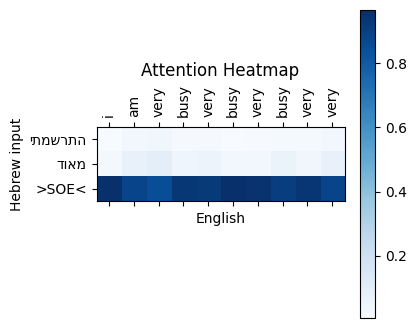

Input: אנחנו מאד דומים
Target: we are very similar
Output: he is very careful very similar home very photogenic very
Attention Shape: torch.Size([1, 10, 4])


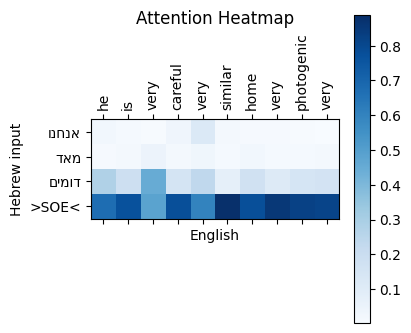

Input: הוא תמיד מתלונן על משכורתו הנמוכה
Target: he is always complaining about his low salary
Output: he is always complaining about his low salary salary salary
Attention Shape: torch.Size([1, 10, 7])


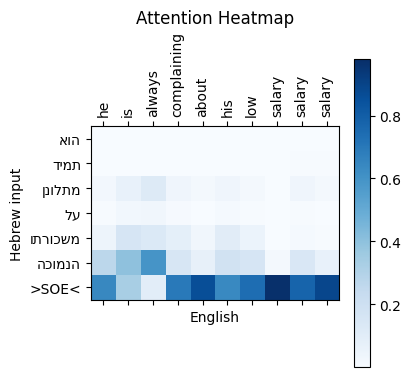

Input: אני מוכן ללכת בעקבותייך
Target: i am ready to follow you
Output: i am ready to follow you <EOS>
Attention Shape: torch.Size([1, 10, 5])


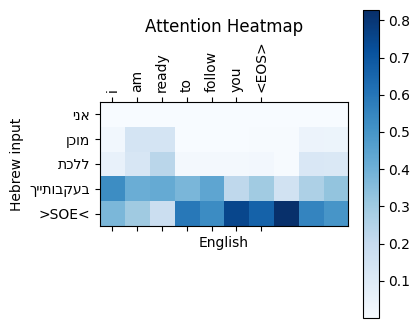

Input: הוא לא חזר מההרים
Target: he isnt back from the mountain
Output: he isnt back from the mountains mountain mountain mountain mountains
Attention Shape: torch.Size([1, 10, 5])


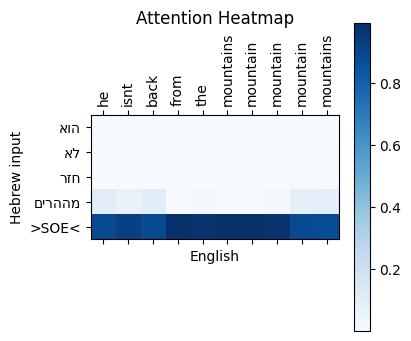

Input: אני בבית
Target: i am at home
Output: i am at home <EOS>
Attention Shape: torch.Size([1, 10, 3])


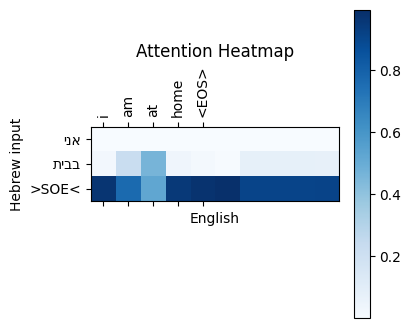

Input: הן נמצאות בכיתה
Target: they are in class
Output: they are in class <EOS>
Attention Shape: torch.Size([1, 10, 4])


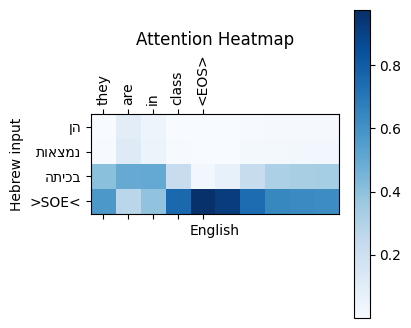

Input: את חיי
Target: you are my life
Output: you are my life poor my mother salary <EOS>
Attention Shape: torch.Size([1, 10, 3])


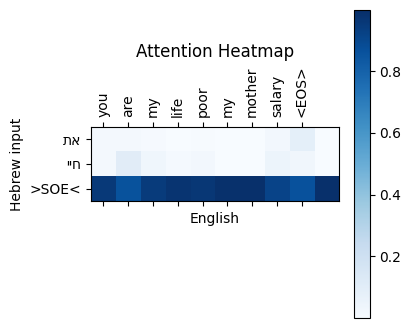

Input: רק התלוצצתי
Target: i am only joking
Output: i am only joking with me <EOS>
Attention Shape: torch.Size([1, 10, 3])


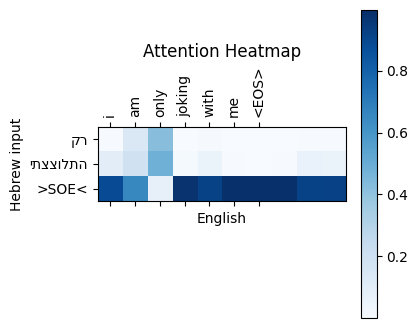

Input: הוא נחשב כחשוד העיקרי על ידי המשטרה
Target: he is considered the prime suspect by the police
Output: he is considered the prime suspect by the police police
Attention Shape: torch.Size([1, 10, 8])


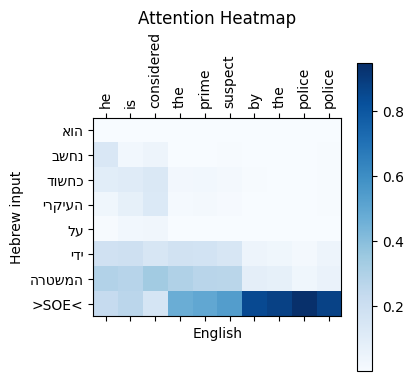

Input: איננו חוששים מהמוות
Target: we arent afraid of death
Output: we arent afraid never never never neither neither neither neither
Attention Shape: torch.Size([1, 10, 4])


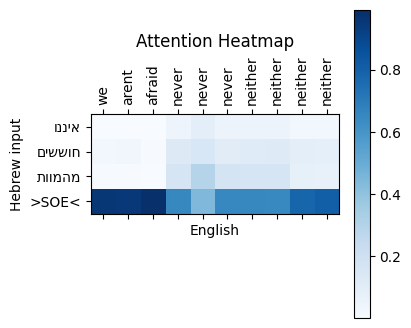

Input: אנחנו עומדים לפגוש אותו הלילה
Target: we are going to meet him tonight
Output: we are going to meet him tonight hated and the
Attention Shape: torch.Size([1, 10, 6])


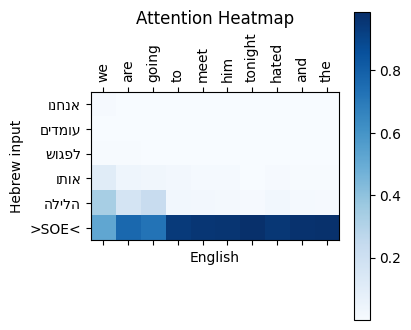

Input: הם גדולים מאוד
Target: they are very big
Output: SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS
Attention Shape: torch.Size([1, 10, 4])


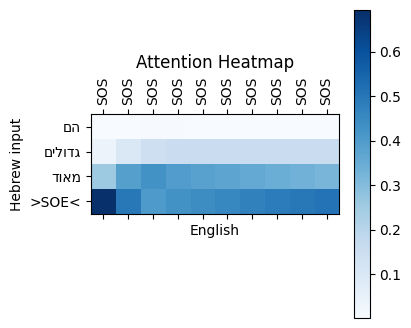

Input: אני עייף מדי כדי לרוץ
Target: i am too tired to run
Output: i am too tired to run into you to run
Attention Shape: torch.Size([1, 10, 6])


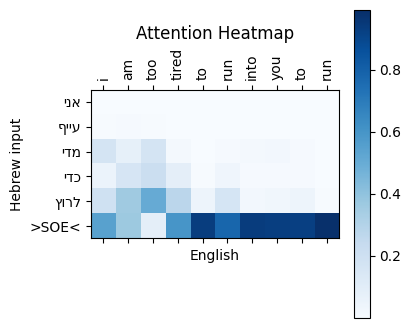

Input: אני מתגורר אצל ידיד
Target: i am staying with a friend
Output: i am staying with a friend <EOS>
Attention Shape: torch.Size([1, 10, 5])


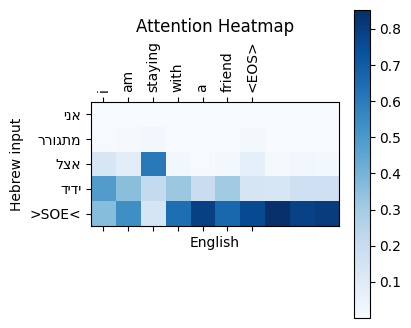

Input: היא אדיבה כלפיו
Target: she is kind to him
Output: she is kind to mouth woman <EOS>
Attention Shape: torch.Size([1, 10, 4])


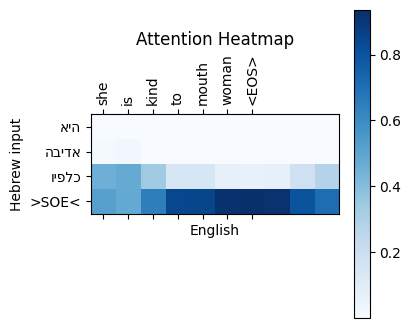

Input: היא אישה שקטה
Target: she is a quiet woman
Output: she is a quiet woman <EOS>
Attention Shape: torch.Size([1, 10, 4])


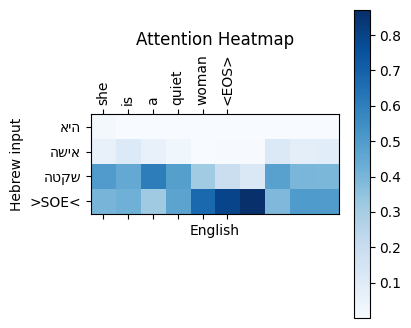

Input: היא סטודנטית באוניברסיטה
Target: she is a college student
Output: she is a college student at the university student <EOS>
Attention Shape: torch.Size([1, 10, 4])


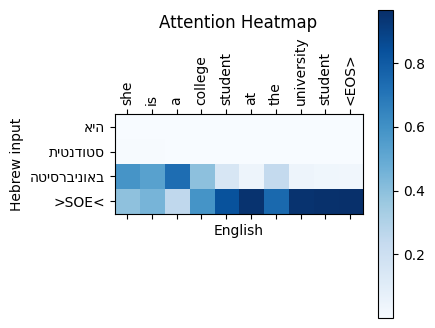

Input: אתה מתכוון לומר שבכוונה אתה מסווה את יופיך
Target: you are saying you intentionally hide your good looks
Output: you are saying you intentionally hide your good looks looks
Attention Shape: torch.Size([1, 10, 9])


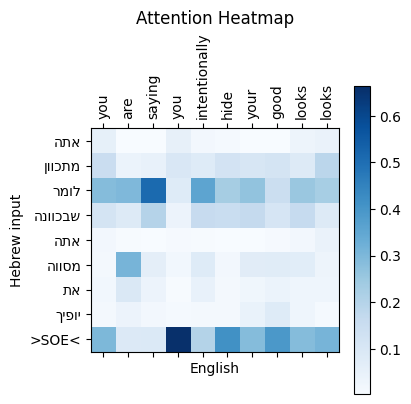

Input: הוא נשוי ואב לשניים
Target: he is married with two children
Output: he is married with two children married mentally married married
Attention Shape: torch.Size([1, 10, 5])


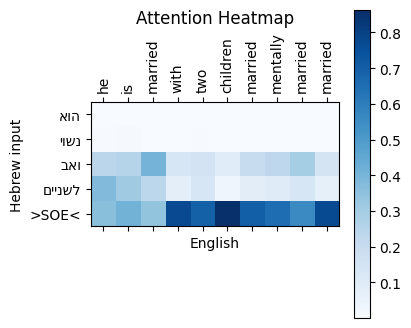

[('היא אדיבה כלפיו', 'she is kind to him', 'she is kind to mouth woman <EOS>'),
 ('היא אישה שקטה', 'she is a quiet woman', 'she is a quiet woman <EOS>'),
 ('היא סטודנטית באוניברסיטה',
  'she is a college student',
  'she is a college student at the university student <EOS>'),
 ('אתה מתכוון לומר שבכוונה אתה מסווה את יופיך',
  'you are saying you intentionally hide your good looks',
  'you are saying you intentionally hide your good looks looks'),
 ('הוא נשוי ואב לשניים',
  'he is married with two children',
  'he is married with two children married mentally married married')]

<Figure size 640x480 with 0 Axes>

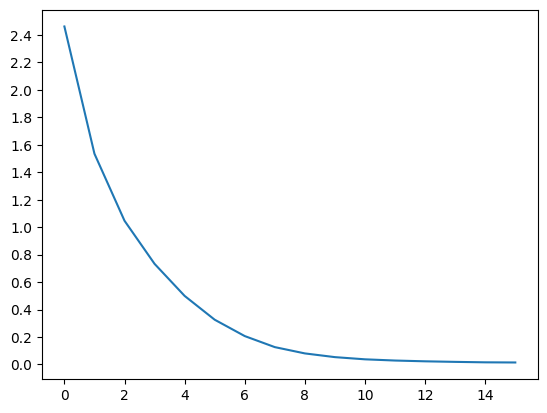

In [55]:


evaluateRandomly_and_plot(encoder, decoder, n=5, return_sentences=False)

# Run with n=1 sample
evaluateRandomly_and_plot(encoder, decoder, n=10, return_sentences=False)

# Run with n=1 sample
evaluateRandomly_and_plot(encoder, decoder, n=5, return_sentences=False)


Input: איני מכשפה
Target: i am not a witch
Output: SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS
Attention Shape: torch.Size([1, 10, 3])


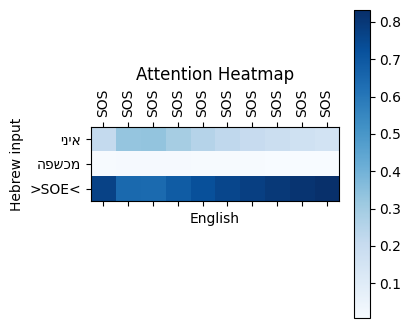

[('איני מכשפה', 'i am not a witch', 'SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS')]

In [56]:
evaluateRandomly_and_plot(encoder, decoder, n=1, return_sentences=False)


Input: הוא נמצא על סיפון האוניה
Target: he is on board the ship
Output: he is on board the ship popular songs thickheaded salary
Attention Shape: torch.Size([1, 10, 6])


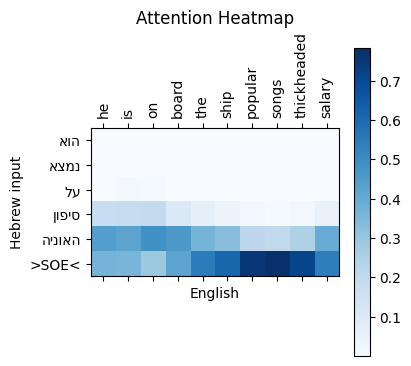

[('הוא נמצא על סיפון האוניה',
  'he is on board the ship',
  'he is on board the ship popular songs thickheaded salary')]

In [57]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch


evaluateRandomly_and_plot(encoder, decoder, n=1, return_sentences=False)


# Added improvments and experimentation:
 - dropout
 - changining batch size
 - changing hidden size


Reading lines...
Read 128133 sentence pairs
Reading lines...
Read 128133 sentence pairs
13.40s (Epoch 5/80, 6.2%) Loss: 1.6719
26.85s (Epoch 10/80, 12.5%) Loss: 0.5444
40.29s (Epoch 15/80, 18.8%) Loss: 0.1268
53.68s (Epoch 20/80, 25.0%) Loss: 0.0313
67.09s (Epoch 25/80, 31.2%) Loss: 0.0160
80.41s (Epoch 30/80, 37.5%) Loss: 0.0161
93.76s (Epoch 35/80, 43.8%) Loss: 0.0124
107.18s (Epoch 40/80, 50.0%) Loss: 0.0127
120.60s (Epoch 45/80, 56.2%) Loss: 0.0121
134.50s (Epoch 50/80, 62.5%) Loss: 0.0081
147.88s (Epoch 55/80, 68.8%) Loss: 0.0064
161.24s (Epoch 60/80, 75.0%) Loss: 0.0061
174.64s (Epoch 65/80, 81.2%) Loss: 0.0058
187.98s (Epoch 70/80, 87.5%) Loss: 0.0402
201.37s (Epoch 75/80, 93.8%) Loss: 0.0112
214.76s (Epoch 80/80, 100.0%) Loss: 0.0061


elapsed_time,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
train_loss_avg,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_plot_loss_avg,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁
elapsed_time,214.75601
epoch,80
train_loss_avg,0.00614
train_plot_loss_avg,0.00614


<Figure size 640x480 with 0 Axes>

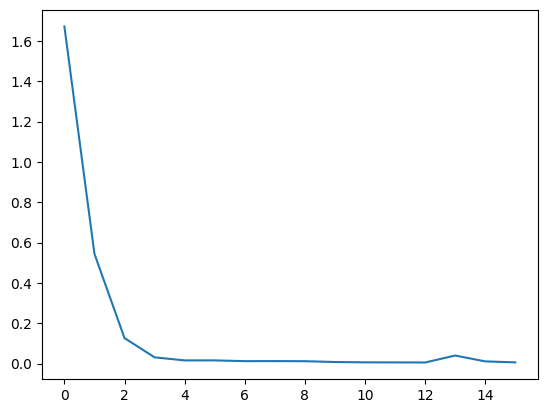

In [93]:

# Initialize wandb
wandb.init(project="seq2seq_translation_avanced_config", config={
    "hidden_size": 256,
    "batch_size": 16,
    "epochs": 80
})

# Load data
hidden_size = 256
batch_size = 16
input_lang, output_lang, train_dataloader = get_dataloader(batch_size)
input_lang, output_lang, train2validation_dataloader = get_dataloader(batch_size)

# Define models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

# Train with wandb logging
train(train_dataloader, encoder, decoder, n_epochs=80, learning_rate=0.001,
      print_every=5, plot_every=5, val_dataloader= train2validation_dataloader)

# Finish wandb run
wandb.finish()

Reading lines...
Read 128133 sentence pairs
13.63s (Epoch 5/80, 6.2%) Loss: 1.7088
27.20s (Epoch 10/80, 12.5%) Loss: 0.6020
40.68s (Epoch 15/80, 18.8%) Loss: 0.1571
54.60s (Epoch 20/80, 25.0%) Loss: 0.0385
68.08s (Epoch 25/80, 31.2%) Loss: 0.0189
81.46s (Epoch 30/80, 37.5%) Loss: 0.0167
94.76s (Epoch 35/80, 43.8%) Loss: 0.0143
108.09s (Epoch 40/80, 50.0%) Loss: 0.0126
121.46s (Epoch 45/80, 56.2%) Loss: 0.0090
134.83s (Epoch 50/80, 62.5%) Loss: 0.0078
148.12s (Epoch 55/80, 68.8%) Loss: 0.0068
161.54s (Epoch 60/80, 75.0%) Loss: 0.0301
174.92s (Epoch 65/80, 81.2%) Loss: 0.0079
188.26s (Epoch 70/80, 87.5%) Loss: 0.0062
201.75s (Epoch 75/80, 93.8%) Loss: 0.0060
215.15s (Epoch 80/80, 100.0%) Loss: 0.0058


elapsed_time,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
train_loss_avg,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_plot_loss_avg,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁
elapsed_time,215.15152
epoch,80
train_loss_avg,0.00577
train_plot_loss_avg,0.00577


<Figure size 640x480 with 0 Axes>

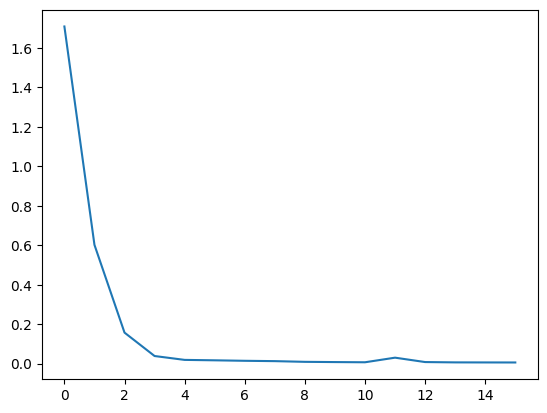

In [97]:
wandb.init(
    project="Improving_Model",
    name="run_with_metrics_248_hidden_16_batch",
    config={
        "hidden_size": 248,
        "batch_size": 16,
        "learning_rate": 0.001,
        "n_epochs": 1000,
        "print_every": 100,
        "plot_every": 100,
    }
)
hidden_size = 248
batch_size = 16
input_lang, output_lang, train_dataloader = get_dataloader(batch_size)
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words , dropout_p=0.2).to(device)


# Train with wandb logging
train(train_dataloader, encoder, decoder, n_epochs=80, learning_rate=0.001,
      print_every=5, plot_every=5, val_dataloader= train2validation_dataloader)

# Finish wandb run
wandb.finish()

## the only thing ive changed here was the dropout rate in the decoder


Reading lines...
Read 128133 sentence pairs
13.48s (Epoch 5/80, 6.2%) Loss: 1.7253
26.86s (Epoch 10/80, 12.5%) Loss: 0.6837
40.16s (Epoch 15/80, 18.8%) Loss: 0.2421
53.54s (Epoch 20/80, 25.0%) Loss: 0.0706
66.88s (Epoch 25/80, 31.2%) Loss: 0.0297
80.29s (Epoch 30/80, 37.5%) Loss: 0.0170
93.63s (Epoch 35/80, 43.8%) Loss: 0.0126
106.99s (Epoch 40/80, 50.0%) Loss: 0.0206
120.45s (Epoch 45/80, 56.2%) Loss: 0.0176
133.84s (Epoch 50/80, 62.5%) Loss: 0.0105
147.11s (Epoch 55/80, 68.8%) Loss: 0.0109
160.44s (Epoch 60/80, 75.0%) Loss: 0.0080
173.74s (Epoch 65/80, 81.2%) Loss: 0.0065
187.04s (Epoch 70/80, 87.5%) Loss: 0.0074
200.46s (Epoch 75/80, 93.8%) Loss: 0.0231
213.79s (Epoch 80/80, 100.0%) Loss: 0.0129


elapsed_time,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
train_loss_avg,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_plot_loss_avg,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁
elapsed_time,213.7872
epoch,80
train_loss_avg,0.01293
train_plot_loss_avg,0.01293


<Figure size 640x480 with 0 Axes>

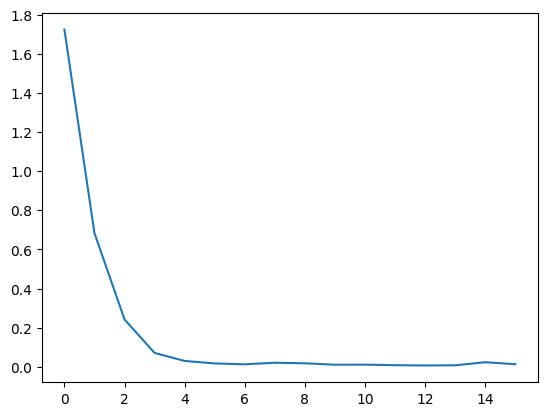

In [98]:
wandb.init(
    project="Improving_Model",
    name="run_with_metrics_248_hidden_16_batch",
    config={
        "hidden_size": 248,
        "batch_size": 16,
        "learning_rate": 0.001,
        "n_epochs": 1000,
        "print_every": 100,
        "plot_every": 100,
    }
)
hidden_size = 248
batch_size = 16
input_lang, output_lang, train_dataloader = get_dataloader(batch_size)
encoder = EncoderRNN(input_lang.n_words, hidden_size,dropout_p=0.2).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words , dropout_p=0.2).to(device)


# Train with wandb logging
train(train_dataloader, encoder, decoder, n_epochs=80, learning_rate=0.001,
      print_every=5, plot_every=5, val_dataloader= train2validation_dataloader)

# Finish wandb run
wandb.finish()

## the only thing ive changed here was the dropout rate in the decoder + ENcoder


In [69]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        finished = torch.zeros(batch_size, dtype=torch.bool, device=device)  # Tracks finished sequences

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input where not finished
                next_input_teacher = target_tensor[:, i].unsqueeze(1)
                # Get predicted next input
                _, topi = decoder_output.topk(1)
                next_input_pred = topi.squeeze(-1).detach()
                # Use teacher forcing only if not finished
                decoder_input = torch.where(finished.unsqueeze(1), next_input_pred, next_input_teacher)
                # Update finished sequences
                current_target = target_tensor[:, i] if target_tensor is not None else None
                if current_target is not None:
                    finished = finished | (current_target == EOS_token)
            else:
                # Without teacher forcing: use predictions
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()
                # Update finished sequences with EOS
                finished = finished | (decoder_input.squeeze() == EOS_token)

            # Early exit if all sequences are finished
            if finished.all():
                break

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []
        finished = torch.zeros(batch_size, dtype=torch.bool, device=device)  # Tracks finished sequences

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: next input is target if not finished
                next_input_teacher = target_tensor[:, i].unsqueeze(1)
                # Predicted next input
                _, topi = decoder_output.topk(1)
                next_input_pred = topi.squeeze(-1).detach()
                # Combine based on finished mask
                decoder_input = torch.where(finished.unsqueeze(1), next_input_pred, next_input_teacher)
                # Update finished sequences
                current_target = target_tensor[:, i]
                finished = finished | (current_target == EOS_token)
            else:
                # Without teacher forcing: use predictions
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()
                finished = finished | (decoder_input.squeeze() == EOS_token)

            # Early exit if all finished
            if finished.all():
                break

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)
        return decoder_outputs, decoder_hidden, attentions

    def forward_step(self, input, hidden, encoder_outputs):
        embedded = self.dropout(self.embedding(input))
        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)
        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)
        return output, hidden, attn_weights